# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

# Import Packages

In [32]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy import special
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import os

# Options

In [33]:
#Standard Reference Data
ds1_date_oi = "24Apr24"
ds1_pat_id = 'BLSA_1742_04_MCIAD_m41'
ds1_pat_tag = ds1_pat_id[-3:]
ds1_slice = 5
ds1_series_tag = f"{ds1_pat_tag}_slice{ds1_slice}_NoNoise_BIC_filter_{ds1_date_oi}"

ds2_date_oi = "23Apr24"
ds2_pat_id = 'BLSA_1935_06_MCIAD_m79'
ds2_pat_tag = ds2_pat_id[-3:]
ds2_slice = 5
ds2_series_tag = f"{ds2_pat_tag}_slice{ds2_slice}_NoNoise_BIC_filter_{ds2_date_oi}"


base_folder = "ExperimentalSets"

post_normalize_data = True

# Signal Functions

In [34]:
def G_biX_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return signal

def G_moX_off(t, con, tau, offSet): 
    signal = con*np.exp(-t/tau) + offSet
    return signal

def G_biX_Ric(t, con_1, con_2, tau_1, tau_2, sigma): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    alpha=(signal/(2*sigma))**2
    Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*special.ive(0, alpha) + 2*alpha*special.ive(1,alpha))
    return Expectation

def G_moX_Ric(t, con, tau, sigma): 
    signal = con*np.exp(-t/tau)
    alpha=(signal/(2*sigma))**2
    Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*special.ive(0, alpha) + 2*alpha*special.ive(1,alpha))
    return Expectation 

In [35]:
file_path = f'{base_folder}/{ds1_pat_id}/{ds1_series_tag}/hprParameter_info_{ds1_date_oi}.pkl'

if os.path.isfile(file_path):
    print('Data was loaded in')
    with open(file_path, 'rb') as handle:
    
        dict = pickle.load(handle)
        ds1_SNR_oi = dict['SNR_oi']
        ds1_iterations = dict['n_noise_realizations']
        ds1_num_multistarts = dict['num_multistarts']
        lambdas = dict['lambdas']
        tdata = dict['tdata']
        ds1_data_file_oi = dict["data_file"]
        ds1_data_slice_oi = dict["data_slice"]
        ds1_model_oi = dict['model_oi']
        ds1_ob_weight = dict['ob_weight']
        ds1_upper_bound = dict['upper_bound']
        ds1_add_noise, ds1_apply_normalization, ds1_model_selection, ds1_multistart_method = dict['options']
        handle.close()

else:
    raise ValueError('There is not a valid SNR file to load')

n_lambdas = len(lambdas)
n_elements = len(tdata)

Data was loaded in


In [36]:
file_path = f'{base_folder}/{ds2_pat_id}/{ds2_series_tag}/hprParameter_info_{ds2_date_oi}.pkl'

if os.path.isfile(file_path):
    print('Data was loaded in')
    with open(file_path, 'rb') as handle:
    
        dict = pickle.load(handle)
        ds2_SNR_oi = dict['SNR_oi']
        ds2_iterations = dict['n_noise_realizations']
        ds2_num_multistarts = dict['num_multistarts']
        lambdas = dict['lambdas']
        tdata = dict['tdata']
        ds2_data_file_oi = dict["data_file"]
        ds2_data_slice_oi = dict["data_slice"]
        ds2_model_oi = dict['model_oi']
        ds2_ob_weight = dict['ob_weight']
        ds2_upper_bound = dict['upper_bound']
        ds2_add_noise, ds2_apply_normalization, ds2_model_selection, ds2_multistart_method = dict['options']
        handle.close()
else:
    raise ValueError('There is not a valid SNR file to load')


Data was loaded in


In [37]:
file_path = f'MB_References/{ds1_pat_id}/SNR_info.pkl'

if os.path.isfile(file_path):
    print('Data was loaded in')
    with open(file_path, 'rb') as handle:
        dict = pickle.load(handle)
        ds1_sigma_SNR = dict['SNR']
        ds1_mask_amplitude = dict['mask_amplitude']
        ds1_date_stamp = dict['date_stamp']
        ds1_n_vert = dict['n_vert']
        ds1_n_hori = dict['n_hori']
        ds1_n_elem = dict['n_elem']
        ds1_mask_shape = dict['mask_shape']
        handle.close()

    print(f'SNR data for {ds1_pat_tag} was loaded in successfully')
    print(f'SNR of brain sigma slice = {ds1_sigma_SNR:.2f}')
else:
    raise ValueError('There is not a valid SNR file to load')

Data was loaded in
SNR data for m41 was loaded in successfully
SNR of brain sigma slice = 159.09


In [38]:
file_path = f'MB_References/{ds2_pat_id}/SNR_info.pkl'

if os.path.isfile(file_path):
    print('Data was loaded in')
    with open(file_path, 'rb') as handle:
        dict = pickle.load(handle)
        ds2_sigma_SNR = dict['SNR']
        ds2_mask_amplitude = dict['mask_amplitude']
        ds2_date_stamp = dict['date_stamp']
        ds2_n_vert = dict['n_vert']
        ds2_n_hori = dict['n_hori']
        ds2_n_elem = dict['n_elem']
        ds2_mask_shape = dict['mask_shape']
        handle.close()

    print(f'SNR data for {ds2_pat_tag} was loaded in successfully')
    print(f'SNR of brain sigma slice = {ds2_sigma_SNR:.2f}')
else:
    raise ValueError('There is not a valid SNR file to load')

Data was loaded in
SNR data for m79 was loaded in successfully
SNR of brain sigma slice = 102.19


# Define General Functions

### Small Helper Functions

In [39]:
########################### Simple Functions ##############################

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1, initial_shape[-1]))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    coeficients = np.where(coeficients == 0, 1-coeficients, coeficients) #to avoid dividing by zero
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

def to_readable(file):
    df = pd.read_pickle(file)
    ALL_TYPES = np.stack(df["Type"].values) #shape: (voxel)
    ALL_DATA = np.stack(df["Data"].values) #shape: (voxel)
    ALL_INDICES = np.stack(df["Indices"].values) #shape: (voxel)

    ALL_ESTIMATES = df["Params"].values #shape: (voxel, lambda, popt)
    ALL_RSS = df["RSS"].values #shape: (voxel, lambda)
    
    return ALL_DATA, ALL_INDICES, ALL_TYPES, ALL_ESTIMATES, ALL_RSS


def get_brain_outline(raw):
    n_vert = raw.shape[0]
    n_hori = raw.shape[1]
    I_outline = np.zeros((n_vert, n_hori))
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            try:
                init_sig = raw[i_vert, i_hori, 0]
                if i_vert > 0:
                    init_sig_up = raw[i_vert-1, i_hori, 0]
                else:
                    init_sig_up = 0
                if i_vert < n_vert - 1:
                    init_sig_dn = raw[i_vert+1, i_hori, 0]
                else:
                    init_sig_dn = 0
                if i_hori > 0:
                    init_sig_lt = raw[i_vert, i_hori - 1, 0]
                else:
                    init_sig_lt = 0
                if i_hori < n_hori - 1:
                    init_sig_rt = raw[i_vert, i_hori + 1, 0]
                else:
                    init_sig_up = 0
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = np.nan
    return I_outline

### Processing Results Functions

In [40]:
##### Regularization Functions on Stored Data

def get_GCV_value(params, RSS, lamb):

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(tdata, *params[:4])
    if (lamb < 1e-7):
        GCVdenominator = len(tdata) - np.linalg.matrix_rank(GCVjacobian)
    else:
        C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
        (n,n) = C_GCV.shape
        identity = np.identity(n)
        GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV

def pull_GCV(est_combos, RSS_combos, lambda_array):

    GCV_hold_values = []

    count_singular = 0

    for iLam in range(len(lambda_array)):    #Loop through all lambda values
        try:
            GCV_value = get_GCV_value(est_combos[iLam], RSS_combos[iLam], lambda_array[iLam])
            GCV_hold_values.append(GCV_value)
        except:
            GCV_hold_values.append(np.inf)
            count_singular += 1

    min_GCV_index = np.argmin(GCV_hold_values)   
    GCV_final_params = est_combos[min_GCV_index, :]
    GCV_RSS = RSS_combos[min_GCV_index]
    GCV_final_lam = lambda_array[min_GCV_index]
    GCV_curves = GCV_hold_values
    
    if count_singular > 0:
        print(f"Pixel had {count_singular} singular GCV values associated with nonzero lambda values")
    
    return GCV_final_lam, GCV_final_params, GCV_RSS, GCV_curves



### Loading and Processing Data Function

In [41]:
def prepare_data(series_tag, pat_id, n_v = ds1_n_vert, n_h = ds1_n_hori, n_lam = n_lambdas):

    nonreg_estimates = np.zeros((n_v, n_h, 5))
    GCV_estimates = np.zeros((n_v, n_h, 5))
    nonreg_RSS = np.ones((n_v, n_h))*np.inf
    GCV_RSS_list = np.ones((n_v, n_h))*np.inf
    GCV_lambdas = np.zeros((n_v, n_h))
    GCV_curves = np.zeros((n_v, n_h, n_lambdas))
    all_data = np.zeros((n_v, n_h, n_elements))
    all_BIC_choices = np.zeros((n_v, n_h))


    data_name = f'{base_folder}/{pat_id}/{series_tag}/brainData_{series_tag}_iteration_0.pkl'

    print("Retrieving data for " + data_name)
    data, indices, types, estimates, RSS = to_readable(data_name)

    for index in range(indices.shape[0]):

        # print(f"Working on horizontal {indices_rs[iter][0]} and verticle {indices_rs[iter][1]}")
        all_BIC_choices[indices[index,0], indices[index,1]] = (types[index]=='biX')
        all_data[indices[index,0], indices[index,1],:] = data[index,:]

        if types[index]=='biX':
            GCV_lambda, GCV_params, GCV_RSS, GCV_curve = pull_GCV(estimates[index], RSS[index], lambdas)

            GCV_estimates[indices[index,0], indices[index,1], :] = GCV_params
            GCV_RSS_list[indices[index,0], indices[index,1]] = GCV_RSS
            GCV_lambdas[indices[index,0], indices[index,1]] = GCV_lambda
            GCV_curves[indices[index,0], indices[index,1], :] = GCV_curve

            nonreg_estimates[indices[index,0], indices[index,1], :] = estimates[index][0,:]
            nonreg_RSS[indices[index,0], indices[index,1]] = RSS[index][0]
        elif types[index] == 'moX':
            GCV_estimates[indices[index,0], indices[index,1], 1:] = [estimates[index][0],0, *estimates[index][1:]]
            nonreg_estimates[indices[index,0], indices[index,1], 1:] = [estimates[index][0],0, *estimates[index][1:]]
            GCV_RSS_list[indices[index,0], indices[index,1]] = RSS[index]
            nonreg_RSS[indices[index,0], indices[index,1]] = RSS[index]
        #The alternative is to be a background type which is disregarded - the parameter values are left as zeros

    all_sets = [np.squeeze(all_BIC_choices), np.squeeze(all_data)]
    nonreg_sets = [np.squeeze(nonreg_estimates), np.squeeze(nonreg_RSS)]
    GCV_sets = [np.squeeze(GCV_estimates), np.squeeze(GCV_RSS_list), np.squeeze(GCV_lambdas), np.squeeze(GCV_curves)]

    return all_sets, nonreg_sets, GCV_sets


# Generate Data Sets

In [42]:
all_sets, nonreg_sets, _ = prepare_data(ds1_series_tag, ds1_pat_id, n_v = ds1_n_vert, n_h = ds1_n_hori)
[ds1_nonreg_estimates, ds1_nonreg_RSS] = nonreg_sets
ds1_BIC_choices, _ = all_sets

if post_normalize_data:
    ds1_nonreg_estimates = post_normalize(ds1_nonreg_estimates)


Retrieving data for ExperimentalSets/BLSA_1742_04_MCIAD_m41/m41_slice5_NoNoise_BIC_filter_24Apr24/brainData_m41_slice5_NoNoise_BIC_filter_24Apr24_iteration_0.pkl


In [43]:
all_sets, nonreg_sets, _ = prepare_data(ds2_series_tag, ds2_pat_id, n_v = ds2_n_vert, n_h = ds2_n_hori)
[ds2_nonreg_estimates, ds2_nonreg_RSS] = nonreg_sets
ds2_BIC_choices, _ = all_sets

if post_normalize_data:
    ds2_nonreg_estimates = post_normalize(ds2_nonreg_estimates)


Retrieving data for ExperimentalSets/BLSA_1935_06_MCIAD_m79/m79_slice5_NoNoise_BIC_filter_23Apr24/brainData_m79_slice5_NoNoise_BIC_filter_23Apr24_iteration_0.pkl


In [44]:
ds1_brain_outline = get_brain_outline(ds1_mask_shape)
ds1_outline_indices = np.where(ds1_brain_outline == 1)

ds2_brain_outline = get_brain_outline(ds2_mask_shape)
ds2_outline_indices = np.where(ds2_brain_outline == 1)

In [45]:
ds1_MWF_mask_region = ds1_nonreg_estimates[np.where(ds1_BIC_choices)[0],np.where(ds1_BIC_choices)[1],0]
ds2_MWF_mask_region = ds2_nonreg_estimates[np.where(ds2_BIC_choices)[0],np.where(ds2_BIC_choices)[1],0]

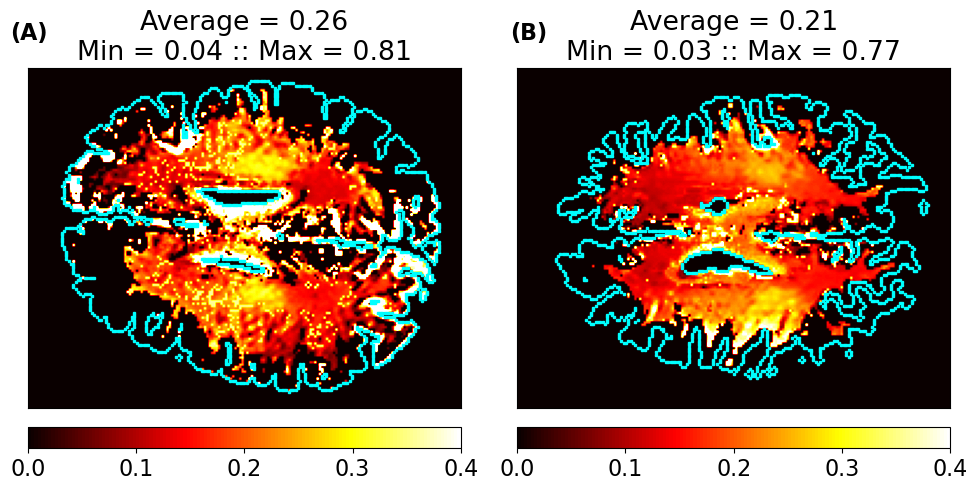

In [46]:
fig, ax = plt.subplots(1,2,figsize=(10,5.5),tight_layout=True)
plt.rc('font', size  = 16)

MWF_cb_map = plt.get_cmap('hot', 128)
# stack_white = np.vstack(((1,0,0,0),MWF_cb_map(np.linspace(0,1,128))))
# MWF_cb_map = colors.ListedColormap(stack_white, name = 'MWF_cb_map')
# MWF_cb_map.set_extremes(over = 'purple')
extend_opt = "neither" #min, max, both, neither
upper_bound = 0.4

# fig.suptitle('Myelin Water Fraction (MWF) Maps' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
im_ds1 = ax[0].imshow(ds1_nonreg_estimates[:,:,0], cmap = MWF_cb_map, vmin = 0, vmax = upper_bound)
ax[0].set_title(f'Average = {np.mean(ds1_MWF_mask_region):.2f}\nMin = {np.min(ds1_MWF_mask_region):.2f} :: Max = {np.max(ds1_MWF_mask_region):.2f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(ds1_outline_indices[1],ds1_outline_indices[0], color = 'cyan', marker = 's', ls = '', markersize = 1.5)

im_ds2 = ax[1].imshow(ds2_nonreg_estimates[:,:,0], cmap = MWF_cb_map, vmin = 0, vmax = upper_bound)
ax[1].set_title(f'Average = {np.mean(ds2_MWF_mask_region):.2f}\nMin = {np.min(ds2_MWF_mask_region):.2f} :: Max = {np.max(ds2_MWF_mask_region):.2f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(ds2_outline_indices[1],ds2_outline_indices[0], color = 'cyan', marker = 's', ls = '', markersize = 1.5)

fig.colorbar(im_ds1,ax=ax[0],fraction=0.046, pad=0.04, location = "bottom", extend = extend_opt)
fig.colorbar(im_ds2,ax=ax[1],fraction=0.046, pad=0.04, location = "bottom", extend = extend_opt)

plt.rc('font', size = 16)
fig.text(0.04,0.85, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.54,0.85, '(B)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

plt.show()